In [2]:
import numpy as np

import torch
import torch.nn as nn
import math

from datasets import load_dataset
from torch.onnx.symbolic_opset9 import tensor
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

In [3]:
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
MAX_LENGTH = 400

In [4]:
imdb_ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load(
    "huggingface/pytorch-transformers", "tokenizer", "bert-base-uncased"
)

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
def collate_imdb(batch):
    texts = []
    for row in batch:
        texts.append(row["text"])

    # (batch_size, MAX_LENGTH)
    inputs = torch.LongTensor(
        tokenizer(texts, padding=True, truncation=True, max_length=MAX_LENGTH).input_ids
    )

    last_words = []
    for text in inputs:
        last_word_token_idx = (text != tokenizer.pad_token_id).nonzero()[-2].item()
        last_words.append(text[last_word_token_idx])
    labels = torch.LongTensor(last_words)
    return inputs, labels


train_data_loader = DataLoader(
    imdb_ds["train"], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_imdb
)
test_data_loader = DataLoader(
    imdb_ds["test"], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_imdb
)

In [6]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10_000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, None], np.arange(d_model)[None, :], d_model
    )
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, d_model, n_heads):
        super().__init__()

        self.input_dim = input_dim
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.wq = nn.Linear(input_dim, d_model)
        self.wk = nn.Linear(input_dim, d_model)
        self.wv = nn.Linear(input_dim, d_model)
        self.wo = nn.Linear(d_model, d_model)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        batch_size, seq_length, _ = x.size()

        # 1. Q, K, V 생성
        Q = self.wq(x)
        K = self.wk(x)
        V = self.wv(x)

        # 1.1 Reshape Q, K, V
        Q = Q.view(batch_size, seq_length, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_length, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_length, self.n_heads, self.d_k).transpose(1, 2)

        # 2. Attention 점수 계산
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # 3. Mask 적용 (필요한 경우)
        if mask is not None:
            # mask shape: [batch_size, 1, 1, seq_length]
            # scores shape: [batch_size, n_heads, seq_length, seq_length]
            # 마스크를 n_heads 차원으로 확장
            mask = mask.repeat(1, self.n_heads, 1, 1)
            scores = scores.masked_fill(mask == 0, -1e9)

        # 4. Softmax 적용 및 Value 와 곱셈
        attention_weights = self.softmax(scores)
        output = torch.matmul(attention_weights, V)

        # 4.1 Transpose 및 Reshape
        output = (
            output.transpose(1, 2)
            .contiguous()
            .view(batch_size, seq_length, self.d_model)
        )

        # 5. 최종 선형 변환
        output = self.wo(output)

        return output

In [8]:
class TransformerLayer(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.multi_head_attention = MultiHeadAttention(input_dim, d_model, n_heads)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model),
        )

        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout()

    def forward(self, x, mask):
        x1 = self.multi_head_attention(x, mask)
        x1 = self.dropout1(x1)
        x1 = self.layer_norm1(x1 + x)

        x2 = self.ffn(x1)
        x2 = self.dropout2(x2)
        return self.layer_norm2(x2 + x1)

In [9]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, dff, max_len):
        super().__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.dff = dff
        self.max_len = max_len

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.Parameter(positional_encoding(max_len, d_model))

        self.layers = nn.ModuleList(
            [TransformerLayer(d_model, d_model, n_heads, dff) for _ in range(n_layers)]
        )

        self.classification = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        mask = (x != tokenizer.pad_token_id).unsqueeze(1).unsqueeze(2)
        seq_len = x.shape[1]

        x = self.embedding(x) * math.sqrt(self.d_model)
        x = x + self.pos_encoding[:, :seq_len]

        for layer in self.layers:
            x = layer(x, mask)

        x = x[:, 0]
        x = self.classification(x)
        return x

In [10]:
my_device = torch.device("cuda")


def accuracy(m, dataloader):
    cnt = 0
    acc = 0

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(my_device), labels.to(my_device)

        preds = m(inputs)
        preds = torch.argmax(preds, dim=-1)

        cnt += labels.shape[0]
        acc += (labels == preds).sum().item()

    return acc / cnt

In [11]:
model = TextClassifier(
    vocab_size=len(tokenizer),
    d_model=32,
    n_layers=5,
    n_heads=4,
    dff=32,
    max_len=MAX_LENGTH,
).to(my_device)

In [13]:
from torch.optim import Adam

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

In [15]:
n_epochs = 50

train_accuracies = []
test_accuracies = []

for epoch in range(n_epochs):
    total_loss = 0.0
    model.train()
    for data in train_data_loader:
        inputs, labels = data
        inputs, labels = inputs.to(my_device), labels.to(my_device)

        optimizer.zero_grad()

        outputs = model(inputs)
        predictions = outputs.squeeze()

        loss = criterion(predictions, labels)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1:3d} | Train Loss: {total_loss}")

    with torch.no_grad():
        model.eval()
        train_acc = accuracy(model, train_data_loader)
        train_accuracies.append(train_acc)
        test_acc = accuracy(model, test_data_loader)
        test_accuracies.append(test_acc)
        print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   1 | Train Loss: 1021.2513822317123
=========> Train acc: 0.584 | Test acc: 0.582
Epoch   2 | Train Loss: 974.3369988203049
=========> Train acc: 0.585 | Test acc: 0.584
Epoch   3 | Train Loss: 941.6438277959824
=========> Train acc: 0.604 | Test acc: 0.590
Epoch   4 | Train Loss: 917.5488213300705
=========> Train acc: 0.619 | Test acc: 0.594
Epoch   5 | Train Loss: 893.7593641281128
=========> Train acc: 0.622 | Test acc: 0.602
Epoch   6 | Train Loss: 874.1114381551743
=========> Train acc: 0.632 | Test acc: 0.597
Epoch   7 | Train Loss: 848.3909306526184
=========> Train acc: 0.652 | Test acc: 0.599
Epoch   8 | Train Loss: 826.3517911434174
=========> Train acc: 0.659 | Test acc: 0.599
Epoch   9 | Train Loss: 797.9342907071114
=========> Train acc: 0.656 | Test acc: 0.601
Epoch  10 | Train Loss: 769.0197402834892
=========> Train acc: 0.675 | Test acc: 0.592
Epoch  11 | Train Loss: 739.2492669820786
=========> Train acc: 0.685 | Test acc: 0.591
Epoch  12 | Train Loss: 701.565

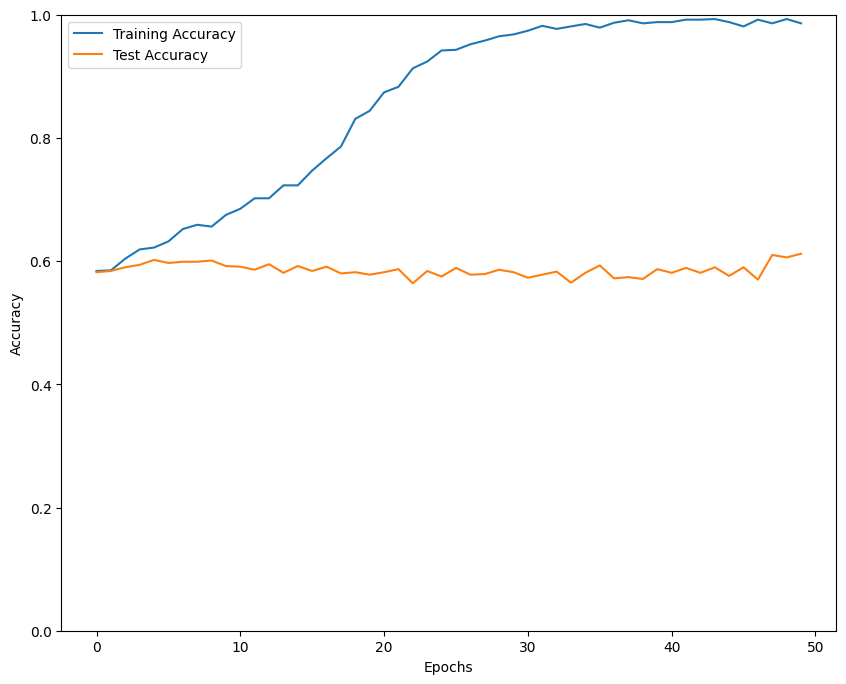

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

x_axis = np.arange(len(train_accuracies))
plt.plot(x_axis, train_accuracies, label="Training Accuracy")
plt.plot(x_axis, test_accuracies, label="Test Accuracy")

plt.legend()

plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.show()

## 결과 분석
- 훈련 정확도는 지속적으로 상승하는 반면, 테스트 정확도는 크게 개선되지 않고 있습니다. 이는 모델이 훈련 데이터에 과적합되고 있음을 시사합니다.
- 특히 15번째 Epoch 이후로 훈련 정확도와 테스트 정확도의 격차가 크게 벌어지고 있습니다.

3. 최고 성능:
   - 테스트 정확도의 최고값은 50번째 에폭에서 0.612입니다.
   - 훈련 정확도는 44번째와 49번째 에폭에서 0.993으로 최고값을 기록했습니다.

4. 학습률과 모델 용량:
   - 훈련 정확도가 지속적으로 상승하는 것으로 보아, 모델의 용량이 충분하고 학습률이 적절하게 설정된 것으로 보입니다.
   - 그러나 테스트 정확도의 개선이 미미한 것을 고려하면, 모델이 훈련 데이터의 노이즈까지 학습하고 있을 가능성이 있습니다.

5. 조기 종료(Early Stopping) 고려:
   - 테스트 정확도가 20번째 에폭 이후로 크게 개선되지 않는 점을 고려하면, 이 시점에서 훈련을 중단하는 것이 과적합을 방지하는 데 도움이 될 수 있습니다.

6. 정규화 기법 필요성:
   - 훈련 정확도와 테스트 정확도의 격차가 큰 것을 고려하면, 드롭아웃(Dropout), L1/L2 정규화, 데이터 증강(Data Augmentation) 등의 정규화 기법을 적용하는 것이 모델의 일반화 성능을 향상시키는 데 도움이 될 수 있습니다.

결론적으로, 이 모델은 훈련 데이터에 대해서는 매우 높은 성능을 보이지만, 새로운 데이터(테스트 데이터)에 대한 일반화 능력이 부족한 것으로 보입니다. 과적합을 줄이고 모델의 일반화 성능을 향상시키기 위한 추가적인 조치가 필요해 보입니다.